# Explore here

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import nltk

In [45]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
data = pd.read_csv(url)
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubscribe,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [46]:
data["is_spam"] = data["is_spam"].apply(lambda x: 1 if x else 0).astype(int)
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubscribe,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [47]:
print(data.shape)
print(f"Spam: {len(data.loc[data.is_spam == 1])}")
print(f"No spam: {len(data.loc[data.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


Eliminamos los duplicados

In [48]:
data = data.drop_duplicates()
data = data.reset_index(inplace = False, drop = True)
data.shape

(2369, 2)

In [49]:
print(data.shape)
print(f"Spam: {len(data.loc[data.is_spam == 1])}")
print(f"No spam: {len(data.loc[data.is_spam == 0])}")

(2369, 2)
Spam: 244
No spam: 2125


#### Preprocesamiento de URLs (Limpieza básica)  


Dividimos las URLs por signos comunes (/, ., -) para descomponerlas en partes. Esto permite que el modelo identifique patrones dentro de los segmentos de las URLs:

In [50]:
import nltk
print("NLTK está instalado correctamente.")


NLTK está instalado correctamente.


In [51]:


# Descargar las stopwords
nltk.download('stopwords')

# Cargar stopwords en inglés
stop_words = set(stopwords.words('english'))
print(stop_words)  # Opcional: Ver las stopwords en inglés


{'ve', 'while', 'our', 'ma', 'won', 'if', 'their', 'haven', "mustn't", 'needn', 'theirs', 'doesn', 'doing', 'about', 'down', 'o', 'has', 'hers', 'here', 'nor', 'her', "isn't", 'once', 'hasn', 'again', "aren't", 'during', 'aren', 'i', 'couldn', 'weren', 'y', 'themselves', "you're", 'them', 'had', 'you', 'until', 'am', 'now', 'or', 'too', 'didn', 'me', 'who', 'he', 'have', 'then', 'do', 'are', 'just', 'being', 'more', 'should', 'mightn', 'shouldn', 'from', 'did', "you'll", 'herself', 'having', 'no', "wouldn't", 'before', 'a', 'as', 'of', 'for', 'after', 'himself', 'in', "didn't", 's', "hasn't", 'not', 'those', 'only', 'ourselves', 'myself', 'each', 'it', 'is', 'when', "wasn't", 'both', 'd', 'ain', 'ours', 'does', 'll', "it's", 'be', 'she', 'were', 'through', 'other', 're', 'yours', 'where', "weren't", 'this', 'his', 'own', 'yourselves', 'whom', 'to', 'hadn', 'at', "needn't", "shan't", 'up', 'will', 'your', 'some', 'its', 'because', 'with', 'between', 'against', 'don', 'mustn', 'these', '

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
def preprocess_url(url):  #función para dividir la url en fragmentos
    clean_url = re.sub(r'[^a-zA-Z0-9]', ' ', url.lower()) #busca cualquier cosa que no sea una letra (a-z, A-Z) o número (0-9) - El símbolo ^ dentro de los corchetes indica "todo excepto" - ' ' reemplaza por espacio. Lower minúsculas.
    tokens = clean_url.split() # crea lista con cada espacio que encuentre , dividir palabras o tokenización
    tokens = [word for word in tokens if word not in stop_words] # eliminar las stop_words más comunes del inglés
    return tokens
    return tokens


In [53]:
# Aplicar la funcioón y ver funcionamiento
data['clean_url'] = data['url'].apply(preprocess_url)

print(data[['url', 'clean_url']].head())

                                                   url  \
0  https://briefingday.us8.list-manage.com/unsubscribe   
1                               https://www.hvper.com/   
2                   https://briefingday.com/m/v4n3i4f3   
3     https://briefingday.com/n/20200618/m#commentform   
4                          https://briefingday.com/fan   

                                                   clean_url  
0  [https, briefingday, us8, list, manage, com, unsubscribe]  
1                                   [https, www, hvper, com]  
2                        [https, briefingday, com, v4n3i4f3]  
3        [https, briefingday, com, n, 20200618, commentform]  
4                             [https, briefingday, com, fan]  


In [54]:
# Configurar pandas para mostrar todas las columnas y filas completas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.max_rows', None)     # Muestra todas las filas
pd.set_option('display.max_colwidth', None) # Evita cortar texto en las celdas
# Volver a valores predeterminados
#pd.reset_option('display.max_columns')
#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_colwidth')


In [55]:
data.head(20)

,url,is_spam,clean_url
0,https://briefingday.us8.list-manage.com/unsubscribe,1,"[https, briefingday, us8, list, manage, com, unsubscribe]"
1,https://www.hvper.com/,1,"[https, www, hvper, com]"
2,https://briefingday.com/m/v4n3i4f3,1,"[https, briefingday, com, v4n3i4f3]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[https, briefingday, com, n, 20200618, commentform]"
4,https://briefingday.com/fan,1,"[https, briefingday, com, fan]"
5,https://www.brookings.edu/interactives/reopening-america-and-the-world/,0,"[https, www, brookings, edu, interactives, reopening, america, world]"
6,https://www.reuters.com/investigates/special-report/health-coronavirus-britain-pub/,0,"[https, www, reuters, com, investigates, special, report, health, coronavirus, britain, pub]"
7,https://www.theatlantic.com/magazine/archive/2020/07/supermarkets-are-a-miracle/612244/,0,"[https, www, theatlantic, com, magazine, archive, 2020, 07, supermarkets, miracle, 612244]"
8,https://www.vox.com/2020/6/17/21294680/john-bolton-book-excerpts-trump-ukraine-china,0,"[https, www, vox, com, 2020, 6, 17, 21294680, john, bolton, book, excerpts, trump, ukraine, china]"
9,https://www.theguardian.com/travel/2020/jun/18/end-of-tourism-coronavirus-pandemic-travel-industry,0,"[https, www, theguardian, com, travel, 2020, jun, 18, end, tourism, coronavirus, pandemic, travel, industry]"


In [56]:
# Unir todas las listas de tokens en una sola lista
all_words = [word for tokens in data['clean_url'] for word in tokens]

# Obtener palabras únicas
unique_words = set(all_words)
print(f"Número total de palabras únicas: {len(unique_words)}")
print(unique_words)


Número total de palabras únicas: 6820
{'effect', 'approach', 'filed', 'index', 'channels', '11592654586', 'snags', '05', 'august', 'scars', 'zoos', 'cheek', 'credit', 'promote', 'aurora', 'sothebys', 'mowalola', 'mercedes', 'must', 'clients', 'alum', 'remote', 'replacement', 'sen', '62c2e999a03a', '1293901', 'water', 'luck', 'unlikely', 'otherworldly', '21307053', 'limit', 'revisiting', '4be4', 'faces', 'travelers', 'dojcinovic', '9884618', 'convinces', 'catch', '5jjderdkdze', 'chocolateforbasil', 'wilsons', 'concept', 'recent', 'policing', 'rice', 'cost', '29345568', 'assets', 'genius', 'vrlfhv6sze0', 'stereotypes', 'special', 'competition', 'dust', 'iduskbn23z0m8', 'b38818f48561889452c77fe736646454', 'reopens', 'sections', 'tied', '09785e274676e46351c70644d2b77215', 'haddish', 'adviser', 'creativecommons', '2017', 'steaks', 'mapjournal', 'sharing', 'robert', '613522', 'constantpodcast', 'shared', 'kosman', 'barred', 'spears', '11592818201', 'a289222eeced', 'flights', 'revtownusa', 'l

In [57]:
from collections import Counter

# Contar las palabras
word_counts = Counter(all_words)

# Mostrar las 20 palabras más comunes
word_counts.most_common(20)


[('https', 2336),
 ('com', 2065),
 ('www', 1511),
 ('2020', 794),
 ('06', 542),
 ('html', 296),
 ('news', 272),
 ('us', 222),
 ('coronavirus', 172),
 ('org', 146),
 ('article', 131),
 ('morningbrew', 105),
 ('story', 104),
 ('nytimes', 101),
 ('daily', 99),
 ('6', 96),
 ('stories', 94),
 ('utm', 90),
 ('youtube', 89),
 ('trump', 88)]

In [58]:
# Palabras en URLs de spam - zip(data['clean_url'], data['is_spam']): Combina las listas de palabras con sus etiquetas (1 o 0) - if label == 1: Filtra solo las URLs de spam (o no spam con label == 0).
spam_words = [word for tokens, label in zip(data['clean_url'], data['is_spam']) if label == 1 for word in tokens]
spam_word_counts = Counter(spam_words)

# Palabras en URLs de no spam
not_spam_words = [word for tokens, label in zip(data['clean_url'], data['is_spam']) if label == 0 for word in tokens]
not_spam_word_counts = Counter(not_spam_words)

# Mostrar las 10 palabras más comunes en spam y no spam
print("Palabras más comunes en spam:")
print(spam_word_counts.most_common(15))

print("\nPalabras más comunes en no spam:")
print(not_spam_word_counts.most_common(15))


Palabras más comunes en spam:
[('https', 238), ('com', 216), ('numlock', 86), ('www', 79), ('substack', 54), ('p', 50), ('sunday', 44), ('manage', 23), ('list', 21), ('morningbrew', 16), ('austinkleon', 12), ('unsubscribe', 11), ('subscribe', 11), ('google', 10), ('daily', 9)]

Palabras más comunes en no spam:
[('https', 2098), ('com', 1849), ('www', 1432), ('2020', 789), ('06', 539), ('html', 293), ('news', 272), ('us', 215), ('coronavirus', 168), ('org', 140), ('article', 131), ('story', 104), ('nytimes', 100), ('6', 96), ('stories', 91)]


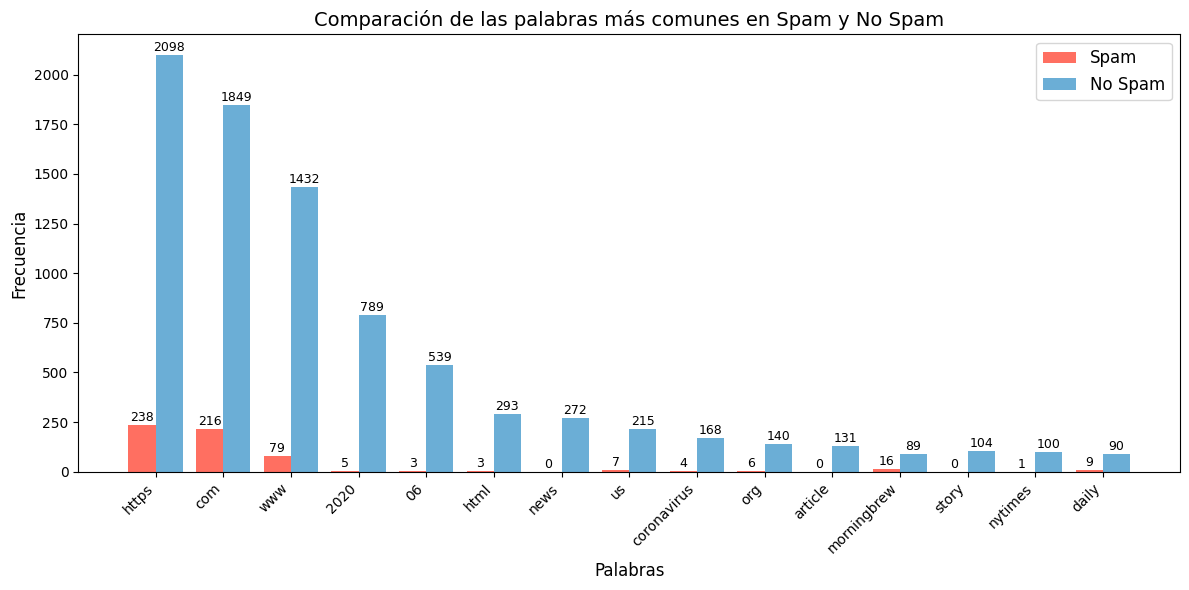

In [66]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Ordenar por frecuencia total
combined_counts = Counter({word: spam_word_counts[word] + not_spam_word_counts[word] for word in all_words})
sorted_words = [word for word, _ in combined_counts.most_common(15)]  # Tomamos solo las 15 palabras más frecuentes

# Obtener frecuencias de palabras en el orden correcto
spam_values = [spam_word_counts[word] for word in sorted_words]
not_spam_values = [not_spam_word_counts[word] for word in sorted_words]

# Configuración del gráfico
x = np.arange(len(sorted_words))  # Posiciones para las palabras
width = 0.4  # Ancho de las barras

fig, ax = plt.subplots(figsize=(12, 6))

# Crear barras para spam y no spam
ax.bar(x - width/2, spam_values, width, label='Spam', color='#FF6F61')
ax.bar(x + width/2, not_spam_values, width, label='No Spam', color='#6BAED6')

# Personalización del gráfico
ax.set_xlabel('Palabras', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Comparación de las palabras más comunes en Spam y No Spam', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(sorted_words, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=12)

# Añadir valores encima de las barras
for i, (spam, not_spam) in enumerate(zip(spam_values, not_spam_values)):
    ax.text(i - width/2, spam + 5, str(spam), ha='center', va='bottom', fontsize=9, color='black')
    ax.text(i + width/2, not_spam + 5, str(not_spam), ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()
